In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from numpy.polynomial import Polynomial
from functools import partial
import pickle
from adaptive_front_helpers import *
from tqdm import tqdm
from scipy.signal import fftconvolve
from math import ceil

In [183]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

Adapted from [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,y) q(y,t) f\big( u(y,t)\big) \ dy \\
    \alpha q_t &= 1 - q - \alpha\beta q f(u) \\
\end{align*}$$

In [3]:
U_style = {
    'linestyle' : '-'
}

Q_style = {
    'linestyle' : '--'
}

threshold_style = {
    'linestyle': ':',
    'color': 'k'
}

sol1_style = {
    'color' : 'b'
}

sol2_style = {
    'color' : 'g'
}

sol3_style = {
    'color' : 'm'
}

In [4]:
params = {
    'theta' :  0.1,
    'alpha' : 20.0,
    'beta'  :  0.2,
    'mu'    :  1.0
}

###############################################

a, b = -100, 200
n = 10**4

###############################################
xs = np.linspace(a,b,n)
h = (b-a)/(n-1)

def firing_rate(u, theta):
    return np.heaviside(u-theta, .5)
    
M = .5*np.exp( - np.abs( np.subtract.outer(xs, xs) ) ) * h
def convW_mat(ys):
    return M@ys

kernel_half_width = ceil(16/h*np.log(10))
kernel_xs = np.arange(-kernel_half_width, kernel_half_width+1)*h
kernel = h*.5*np.exp(-np.abs(kernel_xs))
def convW_fft(ys):
    return fftconvolve(ys, kernel, mode='same')

def RK4_step(F, t, u, dt):
    k1 = F(t,u)
    k2 = F(t+dt/2, u + dt/2*k1)
    k3 = F(t+dt/2, u + dt/2*k2)
    k4 = F(t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

def euler_step(F, t, u, dt):
    return u + dt*F(t, u)

# u is a vector [u, q]
def F_with_params(t, u, *, theta, alpha, beta, mu, convW):
    temp_var = firing_rate(u[0], theta)
    ret = np.array([
        1/mu * (-u[0] + convW(u[1]*temp_var)),
        (1-u[1])/alpha - beta*u[1]*temp_var
    ])
    return ret

def find_root_indices(y):
    root_mask = y[1:]*y[:-1] < 0
    return np.arange(len(y)-1)[root_mask]

def find_roots(xs, ys, window=2):
    roots = []
    for root_index in find_root_indices(ys):
        start_index = root_index-window//2
        locs = slice(start_index, start_index+window)
        p = Polynomial.fit(xs[locs], ys[locs], window-1)
        p_prime = p.deriv()
        x = xs[root_index]
        for _ in range(5):
            x -= p(x)/p_prime(x)
        if not xs[root_index-1] < x < xs[root_index]+1:
            x = xs[root_index]
        roots.append(x)
    return roots

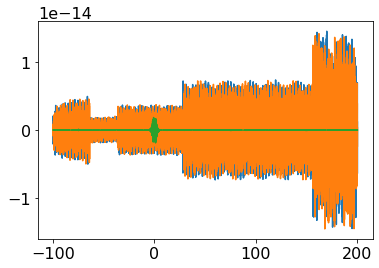

In [5]:
kernel_half_width = ceil(16/h*np.log(10))
kernel_xs = np.arange(-kernel_half_width, kernel_half_width+1)*h
kernel = h*.5*np.exp(-np.abs(kernel_xs))
for f in [np.sin, np.cos, lambda x: np.exp(-x**2)]:
    ys = f(xs)
    plt.plot(xs, convW_mat(ys) - convW_fft(ys))
    # plt.plot(xs, M@f(xs))
plt.show()

In [6]:
F = partial(F_with_params, convW=convW_fft, **params)
c = get_speed(**params)
U = partial(U_numeric, **params)
Q = partial(Q_numeric, **params)

In [7]:
def gamma_from_beta(beta, alpha, **kwargs):
    return 1/(1+alpha*beta)

# Profile

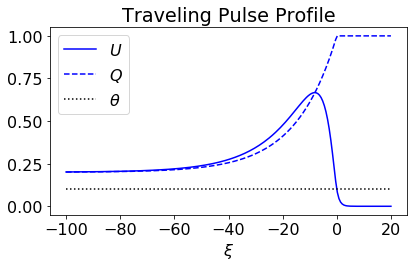

Parameters: $\theta: 0.1$, $\alpha: 20.0$, $\beta: 0.2$, $\mu: 1.0$


In [8]:
profile_xs = np.linspace(-100, 20, 201)
plt.plot(profile_xs, U(profile_xs), **U_style, **sol1_style, label='$U$')
plt.plot(profile_xs, Q(profile_xs), **Q_style, **sol1_style, label='$Q$')
plt.plot(profile_xs, params['theta']+0*profile_xs, **threshold_style, label='$\\theta$')
plt.legend()
plt.title('Traveling Pulse Profile')
plt.xlabel('$\\xi$')
plt.tight_layout()
# plt.savefig('front_profile.eps')
plt.show()
print('Parameters: ' + ', '.join(f'$\\{key}: {val}$'
                                 for key, val in params.items()))

In [9]:
gamma_from_beta(**params)

0.2

In [10]:
def get_speed2(mu, alpha, gamma, theta):
    A = 2*theta*mu*alpha
    B = 2*theta*mu/gamma + 2*theta*alpha - alpha
    C = 2*theta/gamma + 1
    return (-B + np.sqrt(B**2 - 4*A*C))/2/A

# Speed by params

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


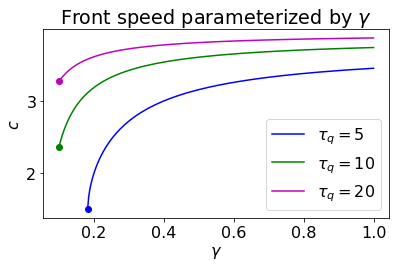

In [11]:
params_less = params.copy()
del(params_less['beta'])
del(params_less['alpha'])

alphas = [5, 10, 20]
def beta_boundary(alpha, theta, **kwargs):
    return 1/alpha*(1/theta - 1)

colors = ['b', 'g', 'm', 'r']

for alpha, color in zip(alphas, colors):
    beta_max = beta_boundary(alpha, **params_less)
    gamma_min = gamma_from_beta(beta_max, alpha, **params_less)
    betas = np.linspace(0, beta_max, 101)
    gammas = gamma_from_beta(betas, alpha, **params_less)
    # cs = get_speed(beta=betas, alpha=alpha, **params_less)
    cs = get_speed2(alpha=alpha, gamma=gammas, **params_less)
    positive_mask = cs>0
    gammas = gammas[positive_mask]
    cs = cs[positive_mask]
    gamma_min = gammas[-1]
    plt.plot(gammas, cs, color=color, label=f'$\\tau_q = {alpha}$')
    plt.plot(gamma_min, cs[-1], 'o', color=color)
    
plt.xlabel('$\\gamma$')
plt.ylabel('$c$')
plt.legend()
plt.title('Front speed parameterized by $\\gamma$')
plt.tight_layout()
# plt.savefig('c_by_gamma.eps')
plt.show()

/home/sage/Documents/research-site/working/adaptive_front_helpers.py:4: RuntimeWarning: invalid value encountered in sqrt
  return (1.0/4.0)*(-2*alpha*beta*mu*theta - 2*alpha*theta + alpha - 2*mu*theta + np.sqrt(4*( lambda base, exponent: base**exponent )(alpha, 2)*( lambda base, exponent: base**exponent )(beta, 2)*( lambda base, exponent: base**exponent )(mu, 2)*( lambda base, exponent: base**exponent )(theta, 2) - 8*( lambda base, exponent: base**exponent )(alpha, 2)*beta*mu*( lambda base, exponent: base**exponent )(theta, 2) - 4*( lambda base, exponent: base**exponent )(alpha, 2)*beta*mu*theta + 4*( lambda base, exponent: base**exponent )(alpha, 2)*( lambda base, exponent: base**exponent )(theta, 2) - 4*( lambda base, exponent: base**exponent )(alpha, 2)*theta + ( lambda base, exponent: base**exponent )(alpha, 2) + 8*alpha*beta*( lambda base, exponent: base**exponent )(mu, 2)*( lambda base, exponent: base**exponent )(theta, 2) - 8*alpha*mu*( lambda base, exponent: base**exponent )(t

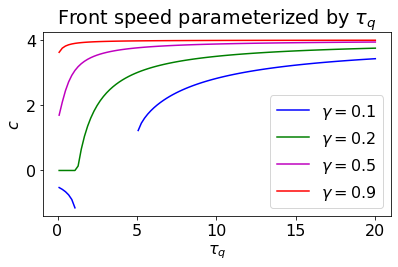

In [12]:
params_less = params.copy()
del(params_less['beta'])
del(params_less['alpha'])

gammas = np.array([0.1, 0.2, 0.5, 0.9])
colors = ['b', 'g', 'm', 'r']

alphas = np.linspace(.1, 20, 101)

for gamma, color in zip(gammas, colors):
    betas = 1/alphas*(1/gamma - 1)
    cs = get_speed(beta=betas, alpha=alphas, **params_less)
    plt.plot(alphas, cs, color=color, label=f'$\\gamma = {gamma}$')
    
plt.xlabel('$\\tau_q$')
plt.ylabel('$c$')
plt.legend()
plt.title('Front speed parameterized by $\\tau_q$')
plt.tight_layout()
# plt.savefig('c_by_tauq.eps')
plt.show()

In [13]:
# params_less = params.copy()
# del(params_less['beta'])
# del(params_less['alpha'])

# betas = [0.1, 0.2, 0.5, 1, 2]
# def alpha_boundary(beta, theta, **kwargs):
#     return 1/beta*(1/theta - 1)

# colors = ['b', 'g', 'm', 'r']

# for beta, color in zip(betas, colors):
#     alpha_max = alpha_boundary(beta, **params_less)
#     alphas = np.linspace(0, alpha_max, 101)
#     cs = get_speed(beta=beta, alpha=alphas, **params_less)
#     plt.plot(alphas, cs, color=color, label=f'$\\beta = {beta}$')
#     plt.plot(alpha_max, cs[-1], 'o', color=color)
    
# plt.xlabel('$\\tau_q$')
# plt.ylabel('$c$')
# plt.legend()
# plt.title('Front speed parameterized by $\\tau_q$')
# plt.tight_layout()
# plt.savefig('c_by_tauq.eps')
# plt.show()

# Simulations

### Traveling Front

In [18]:
u0 = np.zeros((2,n))

# def cos_bell(x, center=0, width=2*np.pi, height=1):
#     return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)
# u0[0] = cos_bell(xs, center=0, width=100)
# u0[1] += 1 # Set initial q to 1

u0[0] = U(xs-20)
u0[1] = Q(xs-20)

t0 = 0
t_final = 30
k = 1e-3

time_integrator = euler_step
# time_integrator = RK4_step    

########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

for step in tqdm(range(steps)):
    ts += [ts[-1] + k]
    u_new = time_integrator(F, ts[-1], us[-1], k)
    us.append(u_new)

100%|██████████| 30000/30000 [00:14<00:00, 2079.48it/s]


In [19]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

frames = 100

fig, ax = plt.subplots(1, 1, figsize=(12,8))

line_u, = ax.plot(xs, us[0][0], label="$u$", **U_style, **sol1_style)
line_q, = ax.plot(xs, us[0][1], label="$q$", **Q_style, **sol1_style)
ax.plot([a, b], [params['theta']]*2, **threshold_style)
ax.legend(loc='right')
ax.set_ylim(*window)
ax.set_xlim(0, b)
# ax.set_xlim(a,b)

def animate(i):
    #print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_q.set_ydata(us[i][1])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, tqdm(np.arange(0, len(ts), len(ts)//frames)), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('traveling_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

 99%|█████████▉| 100/101 [00:03<00:00, 25.48it/s]


### Spatially homogeneous delta-pulse

In [168]:
u0 = np.zeros((2,n))

x0 = 0

u0[0] = U(xs - x0)
u0[1] = Q(xs - x0)

t0 = 0
t_final = 10
k = 1e-3 / 5

time_integrator = euler_step

t_pulse = 1
pulse_amp = .09


########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

for step in tqdm(range(steps)):
    ts.append(ts[-1] + k)
    u_new = time_integrator(F, ts[-1], us[-1], k)
    if abs(ts[-1] - t_pulse) < k/2:
        u_new[0] += pulse_amp
    us.append(u_new)
    
ts = np.array(ts)

100%|██████████| 50000/50000 [00:23<00:00, 2140.29it/s]


In [169]:
fronts = [find_roots(xs, u-params['theta'], window=7)[-1] for u, q in us]

In [170]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

frames = 200

fig, ax = plt.subplots(1, 1, figsize=(12,8))

line_u, = ax.plot(xs, us[0][0], label="$u$", **U_style, **sol1_style)
line_q, = ax.plot(xs, us[0][1], label="$q$", **Q_style, **sol1_style)
ax.plot([a, b], [params['theta']]*2, **threshold_style)

line_u_before, = ax.plot(xs, U(xs - x0), **U_style, **sol2_style)
line_q_before, = ax.plot(xs, Q(xs - x0), **Q_style, **sol2_style)

ax.legend(loc='right')
ax.set_ylim(*window)
ax.set_xlim(-15, 60)
# ax.set_xlim(a,b)

def animate(i):
    #print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_q.set_ydata(us[i][1])
    t = t0 + k*i
    xis = xs - x0 - c*t
    line_u_before.set_ydata(U(xis))
    line_q_before.set_ydata(Q(xis))
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, tqdm(np.arange(0, len(ts), len(ts)//frames)), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('working.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

100%|█████████▉| 200/201 [00:07<00:00, 26.16it/s]


In [171]:
def response(pulse_amp, mu, alpha, beta, theta):
    c = get_speed(mu=mu, alpha=alpha, beta=beta, theta=theta)
    denominator  = theta*c*mu**2/(1+c*mu) - mu*alpha**2*beta*c/2/(1+alpha*beta+c*alpha)**2/(1+c*mu)
    numerator = pulse_amp*c*mu
    return numerator/denominator

In [172]:
response(pulse_amp, **params)

4.56

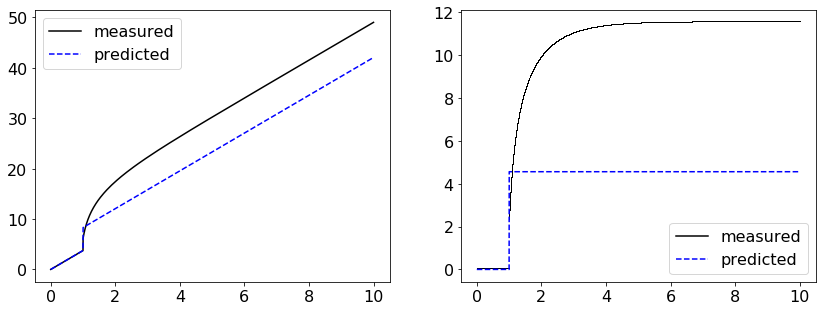

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(ts, fronts, 'k-', label='measured')
axes[0].plot(ts, c*ts-x0 + np.heaviside(ts-t_pulse,0)*response(pulse_amp, **params), 'b--', label='predicted')
axes[0].legend()

axes[1].plot([], [], 'k-', label='measured')
axes[1].plot(ts, fronts - c*ts, 'k,')
axes[1].plot(ts, np.heaviside(ts-t_pulse,0)*response(pulse_amp, **params), 'b--', label='predicted')
axes[1].legend()
# plt.savefig('wave_response_small.png')
plt.show()

pcolormesh

In [174]:
x_window = (-20, 50)
x_window_indices = [np.argmin(np.abs(x - xs)) for x in x_window]

x_pixels = 500
x_stride = (x_window_indices[1] - x_window_indices[0])//x_pixels
x_slice = slice(x_window_indices[0], x_window_indices[1], x_stride)

t_stop_index = int(0.8*len(ts))
y_pixels = 500
y_stride = t_stop_index//y_pixels
y_slice = slice(0, t_stop_index, y_stride)

sol_array = np.array([u[0][x_slice] for u in us[y_slice]]).T

In [175]:
len(sol_array)

584

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


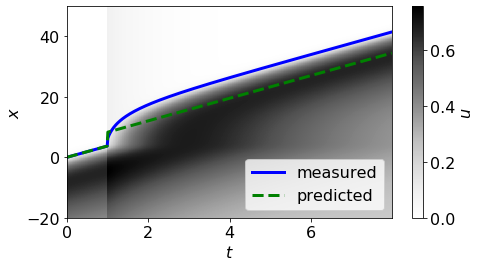

In [189]:
plt.figure(figsize=(7, 4))
x_num_ticks = 5
x_tick_stride = sol_array.shape[1]//x_num_ticks
x_tick_indices = np.arange(0, sol_array.shape[1], x_tick_stride)

plt.pcolormesh(ts[y_slice], xs[x_slice], sol_array, cmap='Greys')
plt.ylabel('$x$')
plt.xlabel('$t$')

plt.plot(ts[y_slice], fronts[y_slice], 'b-', label='measured', linewidth=3)
plt.plot(ts[y_slice], c*ts[y_slice]-x0 + np.heaviside(ts[y_slice]-t_pulse,0)*response(pulse_amp, **params), 'g--', linewidth=3, label='predicted')

plt.colorbar(label = '$u$')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('front_wave_response.eps')
plt.show()